# **Before you start**

*   Go to "*File*" --> "*Save a copy in Drive*"
*   Open that copy (might open automatically)
*   Then continue below

---

# AST MIR-Seminar 2: Building a simple sound classification system

What we are going to do:
*   Download a suitable, simple dataset
*   Have a look at the metadata (csv)
*   Choose a few classes from that dataset
*   Find corresponding audio files
*   Construct a train and test set
*   Extract features (mel spectrogram) and cater for labels
*   Use scikit-learn to classify the test set with a nearest neighbor algorithm
*   Build a confusion matrix

---

# 1. Fetch the Dataset

*   We use ESC-50, a dataset for Environmental Sound Classification
*   Properties:
 * 50 classes
 * 40 files per class
 * each audio file has a length of 10s
*   ***Tasks:***
 * Download, then
 * unzip the dataset

In [ ]:
!wget https://github.com/karoldvl/ESC-50/archive/master.zip

In [ ]:
!unzip master.zip

---

# 2. Import libraries

* We will need a number of libraries. So we import them once and use them throughout the document.

In [ ]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm

---

# 3. Metadata check and quick analysis

***Tasks:***
* Use the pandas module to read the csv file in ESC-50-master/meta/
* Print the first elements of the csv (note: Pandas has a standard function for this)



In [ ]:
fn_csv = 'ESC-50-master/meta/esc50.csv'


### START CODING
df = pd.read_csv(fn_csv)  # pd = pandas dataframe. one-liner to read a csv file
df.head()
### END CODING

Expected output:
```
    filename            fold  target  category        esc10   src_file  take
0   1-100032-A-0.wav    1     0       dog             True    100032    A
1   1-100038-A-14.wav   1     14      chirping_birds  False   100038    A
2   1-100210-A-36.wav   1     36      vacuum_cleaner  False   100210    A
3   1-100210-B-36.wav   1     36      vacuum_cleaner  False   100210    B
4   1-101296-A-19.wav   1     19      thunderstorm    False   101296    A
```



---

# 4. Curate an own dataset ESC-5

***Tasks:***
* a) Use the pandas dataframe *df* from above to find the set of all classes in ESC-50. Sort it, then print the first 10.
* b) We choose 5 classes for our ESC-5 (see *our_classes* variable). Find all files that belong to them. Put the files and their classes in separate lists, but make sure their indices are equal.
 * One idea: Use *df.values* to iterate over the rows of the csv.

* c) Finally, print the first 5 elements of each list as [file, class]-tuples. Also, print the overall lengths of the lists.

In [ ]:
our_classes = ['crying_baby', 'dog', 'rain', 'rooster', 'sneezing']  # Note: This is also our class map for later.
esc5_X = []  # File list
esc5_y = []  # Class list


### START CODING ###
all_classes = sorted(set(df.category))
print(all_classes[:10])

for row in df.values:
  if any(cls == row[3] for cls in our_classes):
    esc5_X.append( row[0] )  # filename
    esc5_y.append( row[3] )  # class

print( list(zip(esc5_X[:5], esc5_y[:5])) )
print('Lengths: esc5_X: {}, esc5_y: {}'.format( len(esc5_X), len(esc5_y) ))
### END CODING ###

Expected output:
```
['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping']
[('1-100032-A-0.wav', 'dog'), ('1-110389-A-0.wav', 'dog'), ('1-17367-A-10.wav', 'rain'), ('1-187207-A-20.wav', 'crying_baby'), ('1-211527-A-20.wav', 'crying_baby')]
Lengths: esc5_X: 200, esc5_y: 200
```



---

# 5. Splitting the dataset into *train* and *test* subsets

***Tasks:***
* ESC-5 is almost ready. Define a suitable split ratio, and use sklearn to do the splitting.
* Print the lengths of your resulting lists. Are they aligned with the ratio?

In [ ]:
### START CODING HERE ###

X_train, X_test, y_train, y_test = train_test_split(esc5_X, esc5_y, test_size=0.2)  # train 80%, test 20%
print('Lengths: X_train: {}, X_test: {}, y_train: {}, y_test: {}'.format(len(X_train), len(X_test), len(y_train), len(y_test)))

### END CODING ###

Expected output:
```
Lengths: X_train: 160, X_test: 40, y_train: 160, y_test: 40
```

---
# 6. Create mel spectrograms

We need to compute features and corresponding labels for each file in our ESC-5.

***Tasks:***
* Define a function that does the following (in this order!):
  * input parameters: an *X*-list, a *y*-list, and *our_classes*
  * loops over the *X*-list (hint: *enumerate* it), and loads each file (.wav) using librosa
  * creates the mel spectrogram from the wave data
  * normalizes each mel spec by dividing it through the number of mel bands.
  * transposes the mel spec
  * appends the mel spec features to a large list
  * creates a target vector consisting of as many values as there are frames 
    * hint: use .shape to see which value you need
  * each value inside the vector must correspond to the index of the class in *our_classes*
    * hint: remember *numpy.ones(...)* ?
    * hint: use *.index(...)* here. Not the best idea, but works here.
  * appends the targets to a large list
  * stacks the large feature and target lists appropriately
  * returns the lists
* Finally, print the shapes of all 4 arrays.

In [ ]:
### START CODING HERE ###
def extract_mel_spec(data_X, data_y, our_classes):
  X = []  # feature tensor
  y = []  # target tensor

  mel_bands = 128
  for i, filename in tqdm(enumerate(data_X)):
    wav_data, sr = librosa.load('ESC-50-master/audio/{}'.format(filename))  # uses the file's sr and stores it to use for the mel_spec

    mel_spec = librosa.feature.melspectrogram(y=wav_data, sr=sr, n_mels=mel_bands)  # Create mel spectrogram. Output shape: (128, 216) (n_mels, frames)
    mel_spec = mel_spec / mel_bands  # Normalization
    mel_spec = mel_spec.T  # Transposition. Output shape: (216, 128)
    mel_spec = mel_spec.astype(np.float16)  # Reduce complexity, saves memory (64bit -> 16bit)
    X.append( mel_spec )  # Append to tensor

    targets = np.ones( mel_spec.shape[0] )  # Create placeholder target vector. Output shape: (216)
    targets = targets * our_classes.index( data_y[i] )  # Convert placeholders with actual class-index
    y.append( targets )  # Append to tensor

  # Stack tensors
  X = np.vstack(X)
  y = np.hstack(y)

  return X, y


# Call the function on our data lists
X_train_ready, y_train_ready = extract_mel_spec(X_train, y_train, our_classes)
X_test_ready, y_test_ready = extract_mel_spec(X_test, y_test, our_classes)

print('\nShapes: X_train_ready: {}, y_train_ready: {}'.format(X_train_ready.shape, y_train_ready.shape))
print('Shapes: X_test_ready: {}, y_test_ready: {}'.format(X_test_ready.shape, y_test_ready.shape))
### END CODING HERE ###

Expected output:
```
Shapes: X_train_ready: (34560, 128), y_train_ready: (34560,)
Shapes: X_test_ready: (8640, 128), y_test_ready: (8640,)
```



---

# 7. Train a nearest neighbor classifier

***Tasks:***
* Use the features and targets from above to train (*fit*) a kNN classifier from scikit-learn, with 5 neighbors and uniform weighting.
* Print the score on the train set, rounded to 4 decimals.
* Print the score on the test set, rounded to 4 decimals.


In [ ]:
# Some feature scaling beforehand...
scaler = StandardScaler()  # zero mean, unit variance normalization (ZMUV)
scaler.fit(X_train_ready)
X_train_ready = scaler.transform(X_train_ready)
X_test_ready = scaler.transform(X_test_ready)


### START CODING HERE ###
model = KNeighborsClassifier(n_neighbors=5, weights='uniform')  # Call the kNN classifier. Look at your imports on top again for a hint.
model.fit(X_train_ready, y_train_ready)  # Fit the classifier using our generated tensors.

print('Train score: {}'.format( np.round(model.score(X_train_ready, y_train_ready), decimals=4) ))
print('Test score: {}'.format( np.round(model.score(X_test_ready, y_test_ready), decimals=4) ))
### END CODING HERE ###

Expected output (or similar):
```
Train score: 0.7735
Test score: 0.4802
```



---

# 8. Plot the confusion matrix
* Use scikit-learn to create a confusion matrix over the test set (one line of code)
* Make sure to normalize the rows
* Plot it
* For reference, print out *our_classes* once more

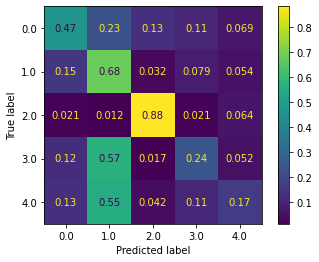

['crying_baby', 'dog', 'rain', 'rooster', 'sneezing']


In [ ]:
### START CODING HERE ###
plot_confusion_matrix(model, X_test_ready, y_test_ready, normalize='true')
plt.show()
print(our_classes)
### END CODING HERE ###

Expected output:

```
-> a coloured confusion matrix here <-

['crying_baby', 'dog', 'rain', 'rooster', 'sneezing']
```